# DEMO: **Đánh giá mô hình Mean Shift Clustering**
<u>Nội dung</u>:
1. Sử dụng Silhouette Scores.
2. Sử dụng Davies-Bouldin Index.
3. Sử dụng Calinski-Harabasz Index.

<u>Cập nhật</u>: **03/2025**

---
### **MÔI TRƯỜNG TRIỂN KHAI ỨNG DỤNG**
---

In [1]:
folder = r"C:\Users\USER\Downloads\chương trình học UEH\môn học kì 4\Machine Learning\Project MeanShift\Team\Mean_Shift_Clustering"

In [2]:
# pip install joblib
# pip install seaborn
# pip install opencv-python
# pip install scikit-learn

In [3]:
# Import các thư viện cần thiết
import sys
sys.path.append(folder)

import joblib as jlb
import seaborn as sns
import cv2
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster        import MeanShift, estimate_bandwidth
from sklearn.metrics        import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from collections            import Counter
import matplotlib.cm        as cm
from sklearn.preprocessing  import StandardScaler
from sklearn.datasets       import make_blobs

In [4]:
data2 = pd.read_csv(folder + '\Data\Mall_Customers.csv')
pd.set_option('display.width', 1000)

X = data2[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
print('Dữ liệu đầu vào:')
print(X.head(10))

# Quan sát phân bố Gender thực tế
print('\nPhân bố Gender thực tế:')
print(data2.groupby('Gender').size())

Dữ liệu đầu vào:
   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40
5   22                  17                      76
6   35                  18                       6
7   23                  18                      94
8   64                  19                       3
9   30                  19                      72

Phân bố Gender thực tế:
Gender
Female    112
Male       88
dtype: int64


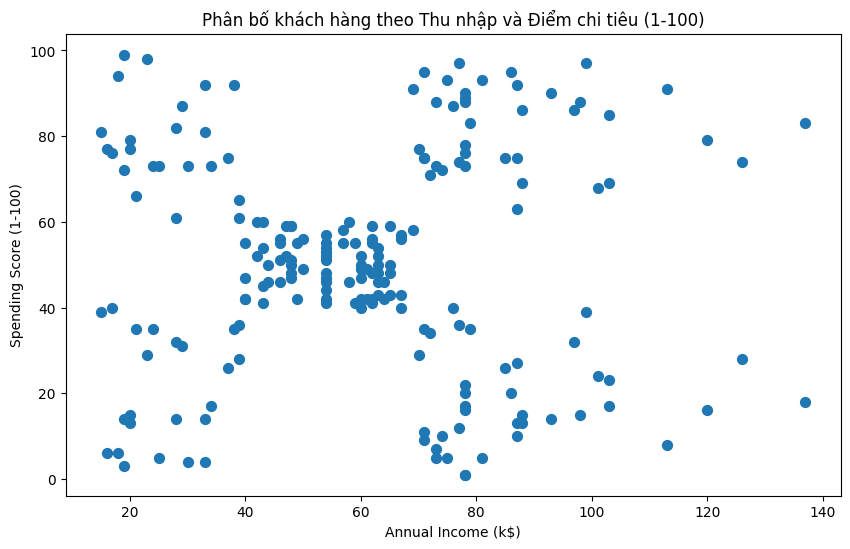

In [5]:
# Sử dụng hai thuộc tính: 'Annual Income (k$)' và 'Spending Score (1-100)'
X = data2[['Annual Income (k$)', 'Spending Score (1-100)']].values
feature_names = ['Annual Income (k$)', 'Spending Score (1-100)']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hiển thị dữ liệu phân tán
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Phân bố khách hàng theo Thu nhập và Điểm chi tiêu (1-100)')
plt.show()

In [6]:
# Thực hiện Mean Shift với các giá trị bandwidth khác nhau
bandwidths = np.linspace(0.3, 1.0, 8)
n_clusters_list = []
silhouette_scores = []
db_scores = []
ch_scores = []

In [7]:
models = []
for bw in bandwidths:
    # Thực hiện Mean Shift với bandwidth hiện tại
    model = MeanShift(bandwidth=bw, bin_seeding=True)
    model.fit(X_scaled)
    labels = model.labels_
    n_clusters = len(np.unique(labels))
    n_clusters_list.append(n_clusters)
    models.append((model, labels, n_clusters))
    
    # Tính các chỉ số đánh giá (chỉ khi có ít nhất 2 cụm)
    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        db_scores.append(davies_bouldin_score(X_scaled, labels))
        ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    else:
        silhouette_scores.append(np.nan)
        db_scores.append(np.nan)
        ch_scores.append(np.nan)

---
## 1. **Sử dụng Silhouette Scores**
---

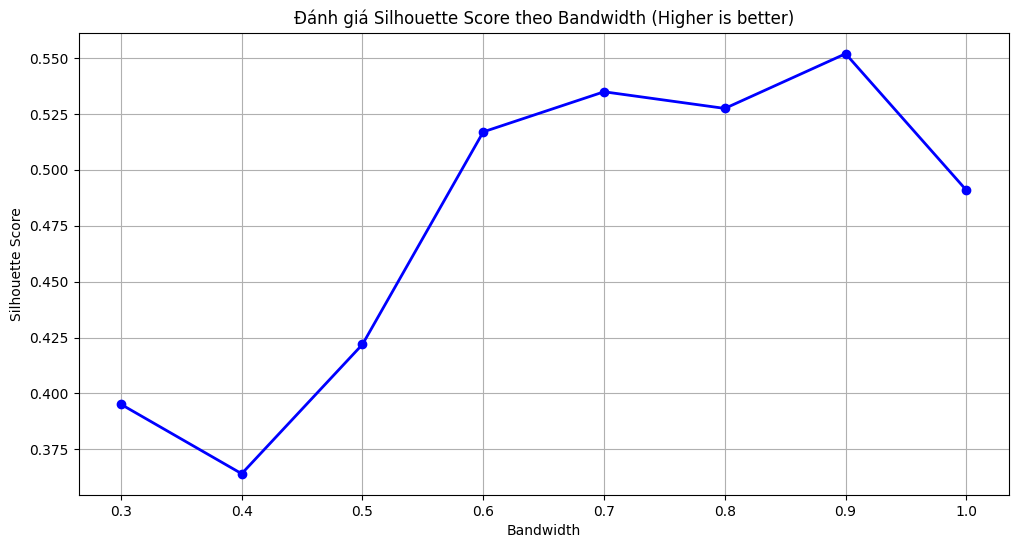

Bandwidth tối ưu theo Silhouette Score: 0.90
Số cụm tương ứng: 5
Giá trị Silhouette Score: 0.5520


In [8]:
# Vẽ biểu đồ Silhouette Score theo bandwidth
plt.figure(figsize=(12, 6))
valid_indices = ~np.isnan(silhouette_scores)
plt.plot(bandwidths[valid_indices], np.array(silhouette_scores)[valid_indices], 'o-', color='blue', linewidth=2)
plt.xlabel('Bandwidth')
plt.ylabel('Silhouette Score')
plt.title('Đánh giá Silhouette Score theo Bandwidth (Higher is better)')
plt.grid(True)
plt.xticks(np.arange(min(bandwidths), max(bandwidths) + 0.1, 0.1))
plt.show()

# Tìm bandwidth có Silhouette Score cao nhất
best_silhouette_idx = np.nanargmax(silhouette_scores)
best_silhouette_bw = bandwidths[best_silhouette_idx]
best_silhouette_n_clusters = n_clusters_list[best_silhouette_idx]
best_model_silhouette = models[best_silhouette_idx]

print(f"Bandwidth tối ưu theo Silhouette Score: {best_silhouette_bw:.2f}")
print(f"Số cụm tương ứng: {best_silhouette_n_clusters}")
print(f"Giá trị Silhouette Score: {silhouette_scores[best_silhouette_idx]:.4f}")

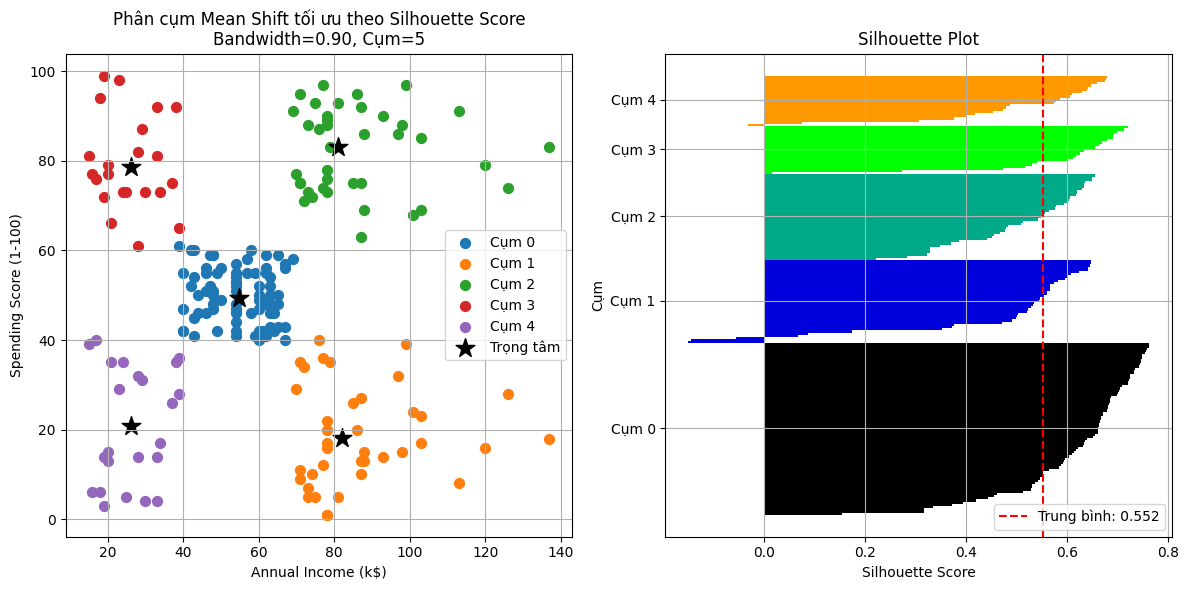

In [9]:
# Hiển thị kết quả phân cụm với bandwidth tối ưu theo Silhouette Score
ms_best, labels_best, _ = best_model_silhouette
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ phân cụm
plt.subplot(1, 2, 1)
for i in range(best_silhouette_n_clusters):
    plt.scatter(X[labels_best == i, 0], X[labels_best == i, 1], s=50, label=f'Cụm {i}')

# Hiển thị trọng tâm các cụm
centers = scaler.inverse_transform(ms_best.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', marker='*', label='Trọng tâm')

plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title(f'Phân cụm Mean Shift tối ưu theo Silhouette Score\nBandwidth={best_silhouette_bw:.2f}, Cụm={best_silhouette_n_clusters}')
plt.legend()
plt.grid(True)

# Vẽ Silhouette Plot
plt.subplot(1, 2, 2)
silhouette_vals = silhouette_samples(X_scaled, labels_best)
y_ticks = []
y_lower, y_upper = 0, 0

for i in range(best_silhouette_n_clusters):
    cluster_silhouette_vals = silhouette_vals[labels_best == i]
    cluster_silhouette_vals.sort()
    
    y_upper += len(cluster_silhouette_vals)
    color = cm.nipy_spectral(i / best_silhouette_n_clusters)
    
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)
    
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--", label=f'Trung bình: {silhouette_avg:.3f}')
    
plt.yticks(y_ticks, [f'Cụm {i}' for i in range(best_silhouette_n_clusters)])
plt.xlabel("Silhouette Score")
plt.ylabel("Cụm")
plt.title("Silhouette Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---
## 2. **SỬ DỤNG DAVIES-BOULDIN INDEX**
---

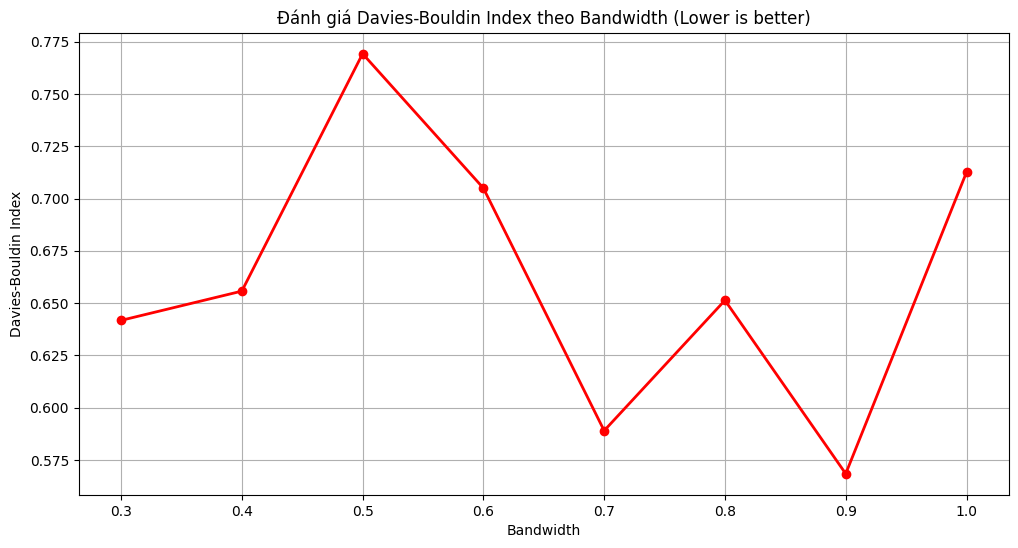

Bandwidth tối ưu theo Davies-Bouldin Index: 0.90
Số cụm tương ứng: 5
Giá trị Davies-Bouldin Index: 0.5685


In [10]:
# Vẽ biểu đồ Davies-Bouldin Index theo bandwidth
plt.figure(figsize=(12, 6))
valid_indices = ~np.isnan(db_scores)
plt.plot(bandwidths[valid_indices], np.array(db_scores)[valid_indices], 'o-', color='red', linewidth=2)
plt.xlabel('Bandwidth')
plt.ylabel('Davies-Bouldin Index')
plt.title('Đánh giá Davies-Bouldin Index theo Bandwidth (Lower is better)')
plt.grid(True)
plt.show()

# Tìm bandwidth có Davies-Bouldin Index thấp nhất
best_db_idx = np.nanargmin(db_scores)
best_db_bw = bandwidths[best_db_idx]
best_db_n_clusters = n_clusters_list[best_db_idx]
best_model_db = models[best_db_idx]

print(f"Bandwidth tối ưu theo Davies-Bouldin Index: {best_db_bw:.2f}")
print(f"Số cụm tương ứng: {best_db_n_clusters}")
print(f"Giá trị Davies-Bouldin Index: {db_scores[best_db_idx]:.4f}")

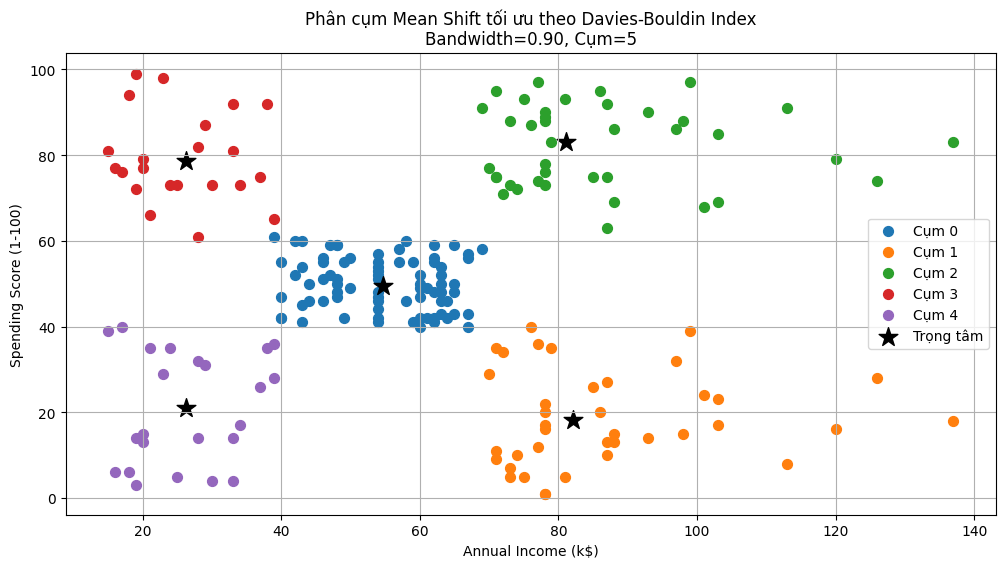

In [11]:
# Hiển thị kết quả phân cụm với bandwidth tối ưu theo Davies-Bouldin Index
ms_best_db, labels_best_db, _ = best_model_db
plt.figure(figsize=(12, 6))

for i in range(best_db_n_clusters):
    plt.scatter(X[labels_best_db == i, 0], X[labels_best_db == i, 1], s=50, label=f'Cụm {i}')

# Hiển thị trọng tâm các cụm
centers_db = scaler.inverse_transform(ms_best_db.cluster_centers_)
plt.scatter(centers_db[:, 0], centers_db[:, 1], s=200, c='black', marker='*', label='Trọng tâm')

plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title(f'Phân cụm Mean Shift tối ưu theo Davies-Bouldin Index\nBandwidth={best_db_bw:.2f}, Cụm={best_db_n_clusters}')
plt.legend()
plt.grid(True)
plt.show()

---
## 3. **SỬ DỤNG CALINSKI-HARABASZ INDEX**
---

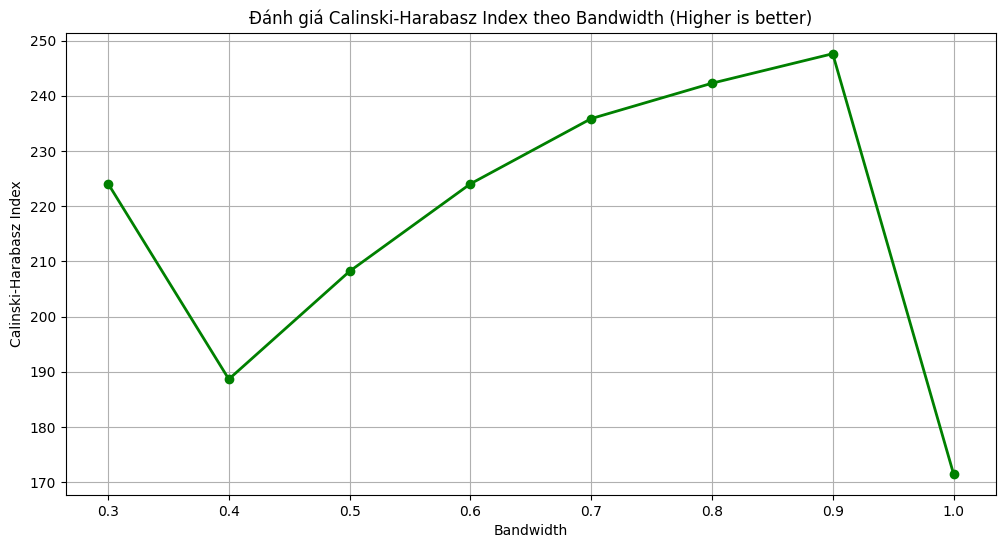

Bandwidth tối ưu theo Calinski-Harabasz Index: 0.90
Số cụm tương ứng: 5
Giá trị Calinski-Harabasz Index: 247.6121


In [12]:
# Vẽ biểu đồ Calinski-Harabasz Index theo bandwidth
plt.figure(figsize=(12, 6))
valid_indices = ~np.isnan(ch_scores)
plt.plot(bandwidths[valid_indices], np.array(ch_scores)[valid_indices], 'o-', color='green', linewidth=2)
plt.xlabel('Bandwidth')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Đánh giá Calinski-Harabasz Index theo Bandwidth (Higher is better)')
plt.grid(True)
plt.show()

# Tìm bandwidth có Calinski-Harabasz Index cao nhất
best_ch_idx = np.nanargmax(ch_scores)
best_ch_bw = bandwidths[best_ch_idx]
best_ch_n_clusters = n_clusters_list[best_ch_idx]
best_model_ch = models[best_ch_idx]

print(f"Bandwidth tối ưu theo Calinski-Harabasz Index: {best_ch_bw:.2f}")
print(f"Số cụm tương ứng: {best_ch_n_clusters}")
print(f"Giá trị Calinski-Harabasz Index: {ch_scores[best_ch_idx]:.4f}")

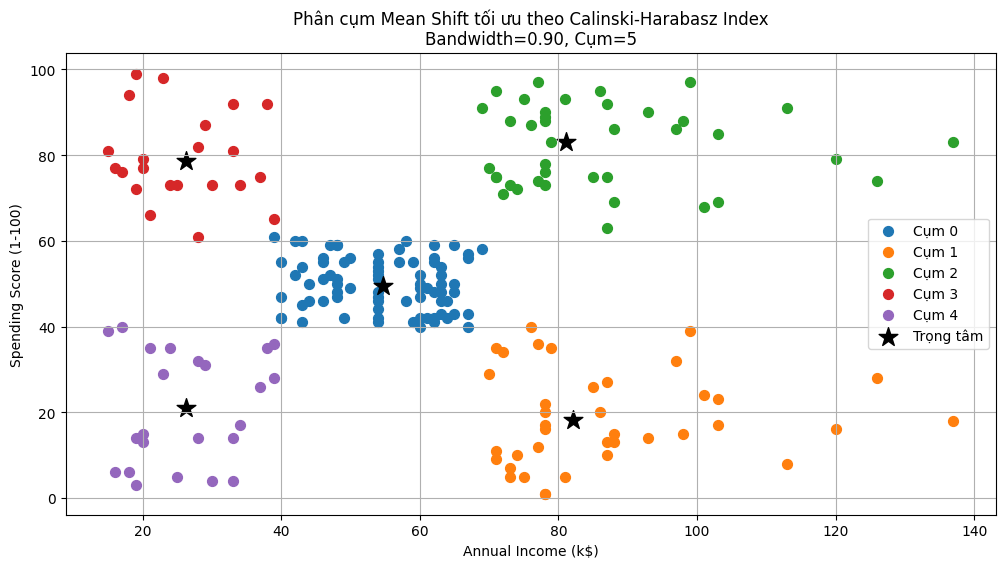

In [13]:
# Hiển thị kết quả phân cụm với bandwidth tối ưu theo Calinski-Harabasz Index
ms_best_ch, labels_best_ch, _ = best_model_ch
plt.figure(figsize=(12, 6))

for i in range(best_ch_n_clusters):
    plt.scatter(X[labels_best_ch == i, 0], X[labels_best_ch == i, 1], s=50, label=f'Cụm {i}')

# Hiển thị trọng tâm các cụm
centers_ch = scaler.inverse_transform(ms_best_ch.cluster_centers_)
plt.scatter(centers_ch[:, 0], centers_ch[:, 1], s=200, c='black', marker='*', label='Trọng tâm')

plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title(f'Phân cụm Mean Shift tối ưu theo Calinski-Harabasz Index\nBandwidth={best_ch_bw:.2f}, Cụm={best_ch_n_clusters}')
plt.legend()
plt.grid(True)
plt.show()